# Statistical Process Control (SPC) Algorithm

## 1 - SPC Overview

#### Theoretical Refresher from Change Detection class (05/3/2024)
_Gama, et. al, Learning with Drift Detection, Lecture Notes in Computer
Science 3171, Springer._

- Suppose a sequence of examples in the form $< \overline{xi}, yi >$
- The current decision model classifies each example in the sequence
- In the 0-1 loss function, predictions are either True or False
- The predictions of the learning algorithm are sequences: $True$,$False$,$True$,$False$,$True$,$False$,$True$,$True$,$True$,$False$,...
- The Error is a random variable from Bernoulli trials
- The Binomial distribution gives the general form of the probability of observing a $False$: $p_i = \frac{{\#F}}{{i}}$ and $s_i = \sqrt{\frac{{p_i(1 - p_i)}}{{i}}}$, where i is the number of trials

The Statistical Process Control algorithm maintains two registers:
- $P_{min}$ and $S_{min}$ such that $P_{min} + S_{min} = min(p_i + s_i)$. The minimum error rate taking into account the variance of the estimator

At example $j$, the error of the learning algorithm will be:
- In-control if $p_j + s_j < P_{min} + 2 ∗ S_{min}$
- Out-control if $p_j + s_j \geq P_{min} + 3 ∗ S_{min}$
- Warning Level if $P_{min} + 3 ∗ S_{min} \geq p_j + s_j > P_{min} + 2 ∗ S_{min}$

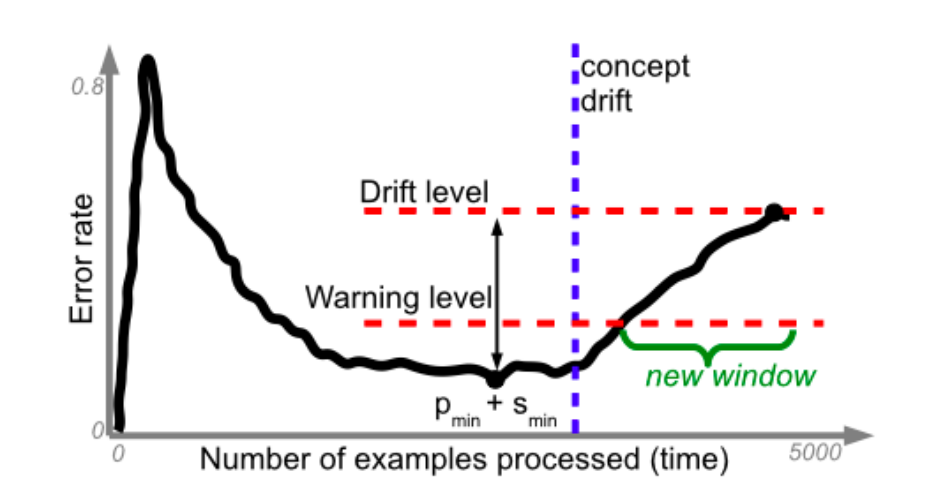

- At example $j$ the current decision model classifies the example 
- Compute the error and variance: $p_j$ and $s_j$
- If the error is
    - In-control: The current model is updated. Incorporate the example in the decision model
    - Warning: Maintain the current model. First Time: the lower limit of the window is: $L_{warning} = j$
    - Out-Control: Re-learn a new model using as training set the set of examples $[L_{warning} , j]$

## 2- SPC Module Implementation

The SPC module implements the detector class (SPCAlgorithm). Within this class, the following methods are defined:
- \_\_init__() : class initialization. It requires a function that initializes a river compatible estimator (ML model) to be given by the user.
- _update() : receives the ML model result, calculates the current error rate (p) and variance (s) and updates the Pmin and Smin if needed. Then it checks and returns the process status (In-control, Warning, Out-control).
- _model_train() : trains the ML model with the last iput or with a batch of inputs if re-training is needed.
- _reset_model() : re-initializes the ML model if re-training is needed, by calling the estimator initialization function given by the user..
- model_control() : wrapper function that calls reset_model() and train_model(), depending on the status returned by update(). This function is intended to be called by the user from outside the module.
- process_plot() : generates plots containing the process control results. This function is intended to be called by the user from outside the module.

In [1]:
import river
import matplotlib.pyplot as plt


status_dict = {
    "In-control"   : 0,
    "Warning Level": 1,
    "Out-control"  : 2
}

class SPCAlgorithm:
    def __init__(self, init_estimator):
        self.Pmin = 1.0
        self.Smin = 0.0
        self.num_negative = 0
        self.num_examples = 0
        self.error_rates = [] # for plotting
        self._init_estimator = init_estimator
        self._reset_model()
        self.warn = -1
        self.warning_level = []
        self.drift_level = []
        self.states = []

    def _update(self, y):
        # Update counts
        self.num_examples += 1
        if (y == False):
            self.num_negative += 1
        # Calculate p and s
        p = self.num_negative / self.num_examples
        s = (p * (1 - p) / self.num_examples) ** 0.5
        # Update Pmin and Smin
        if p + s != 0 and p + s < self.Pmin + self.Smin:
            self.Pmin = p
            self.Smin = s
        # Check process status
        self.warning_level.append(self.Pmin + 2 * self.Smin)        
        self.drift_level.append(self.Pmin + 3 * self.Smin)
        if p + s < self.Pmin + 2 * self.Smin:
            status = "In-control"
        elif p + s >= self.Pmin + 3 * self.Smin:
            status = "Out-control"
        else:
            status = "Warning Level"
        self.error_rates.append(p)
        return status        

    def _model_train(self, data):
        for i in range(data.shape[0]):
            try: # batch training
                x, y = data.iloc[i, :-1], data.iloc[i, -1]
            except: # single sample fitting
                x, y = data[:-1], data[-1]
        self.model.learn_one(x, y)
    
    def _reset_model(self):
        self.model = self._init_estimator()

    def model_control(self, data, sample_id):
        x = data.iloc[sample_id, :-1]
        y = data.iloc[sample_id, -1]
        y_pred = self.model.predict_one(x)

        status = self._update(y_pred==y)        
        # check detector status
        if status == 'Warning Level' and self.warn == -1 and sample_id!=0:
            self.warn = sample_id
        elif status == 'Out-control':
            self._reset_model()
            self._model_train(data.iloc[self.warn:sample_id+1,:]) # batch
        else:
            self._model_train(data.iloc[sample_id,:]) # single sample
        
        self.states.append(status_dict[status])
        return status, y, y_pred

    def process_plot(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        # Plot error and levels
        ax1.plot(range(1, len(self.error_rates) + 1), self.error_rates, marker='o', markersize=1, label='Error Rate')
        ax1.plot(range(1, len(self.warning_level) + 1), self.warning_level, color='r', linestyle='--', label='Warning Level')
        ax1.plot(range(1, len(self.drift_level) + 1), self.drift_level, color='g', linestyle='--', label='Drift Level')
        ax1.set_xlabel('Number of processed samples')
        ax1.set_ylabel('Error rate')
        ax1.set_title('Error Rate Across Processed Samples with SPC Indicators')
        ax1.grid(True)
        ax1.legend()
        # Plot states
        ax2.plot(range(1, len(self.states) + 1), self.states, marker='o', linestyle='-', color='b')
        ax2.set_xlabel('Number of processed samples')
        ax2.set_ylabel('State')
        ax2.set_title('State Across Processed Samples')
        ax2.set_yticks([0, 1, 2])
        ax2.set_yticklabels(['Normal', 'Warning', 'Out of Control'])
        ax2.grid(True)
        plt.tight_layout()
        plt.show()

## 3 - Example Usage

### 3.1 - Data

TBD: ...brief presentation of our data...

### 3.2 - User Manual

#### Setup:
- Download the SPC_module folder from https://github.com/miguelFigSilva/dsm_SPC
- Install the requirements (pip install -r SPC_module/requirements.txt)

Once the setup is completed, we can start using the module.

#### Initialization:
- Import the required packages (including the SPC module)

In [2]:
from SPC_module.SPC import SPCAlgorithm
from river import compat
from river import metrics
from river import preprocessing
from sklearn import linear_model
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")

- Create a function that initializes an estimator (machine learning model) of the user's choice. This estimator learning phase is the process we want to control using the SPC module.
    - Remark: The user shall ensure that the chosen estimator is compatible with the river package. 
    - Hint: there are available functions that help with this, e.g. river.compat.convert_sklearn_to_river().

In [3]:
def init_estimator_SGDClassifier():
    model = preprocessing.StandardScaler()
    model |= compat.convert_sklearn_to_river(
    estimator=linear_model.SGDClassifier(
        loss='log_loss',                   # 'log_loss' gives LOGISTIC REGRESSION. Uncomment to use it.
        #loss='hinge',                     # 'hinge' gives a LINEAR SVM. Uncomment to use it.
        #loss='perceptron',                # 'perceptron' is the linear loss used by the PERCEPTRON algorithm. Uncomment to use it.
        #loss='modified_huber',            # 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates. Uncomment to use it.
        #loss='squared_hinge',             # 'squared_hinge' is like hinge but is quadratically penalized. Uncomment to use it.
        eta0=0.01,
        learning_rate='constant'
    ),
    classes=[False, True]
    )
    return model

- Get the data stream
- Initialize the SPC detector
- Initialize the metrics

In [4]:
PATH = os.path.dirname(os.path.abspath('__file__'))
data_stream = pd.read_csv(f"{PATH}/data/synthetic_dataset.csv")

spc_detector = SPCAlgorithm(init_estimator_SGDClassifier)

metric = metrics.Accuracy()

#### Running the Algorithm:

Once initialized, the SPC algorithm can run on the data stream. It will monitor the learning process of the chosen estimator and detect any anomalies or drifts.
The SPC algorithm provides real-time feedback on the status of the process. It 
categorizes the process into three states:
- Normal: The process is operating within expected parameters.
- Warning: Deviation detected, indicating a potential issue.
- Out of Control: Significant deviation detected, requiring intervention.

The user may use the algorithm’s output within the control loop.

- Implement the control loop
    - Run the algorithm
    - Monitor the detector outputs
    - Visualize results using the provided plotting functions

1000 samples: Accuracy: 76.00%
2000 samples: Accuracy: 76.25%
3000 samples: Accuracy: 77.33%
4000 samples: Accuracy: 77.70%
5000 samples: Accuracy: 77.62%
6000 samples: Accuracy: 77.38%
7000 samples: Accuracy: 77.46%
8000 samples: Accuracy: 77.40%
9000 samples: Accuracy: 77.51%
10000 samples: Accuracy: 77.51%
10000 samples: Accuracy: 77.51%


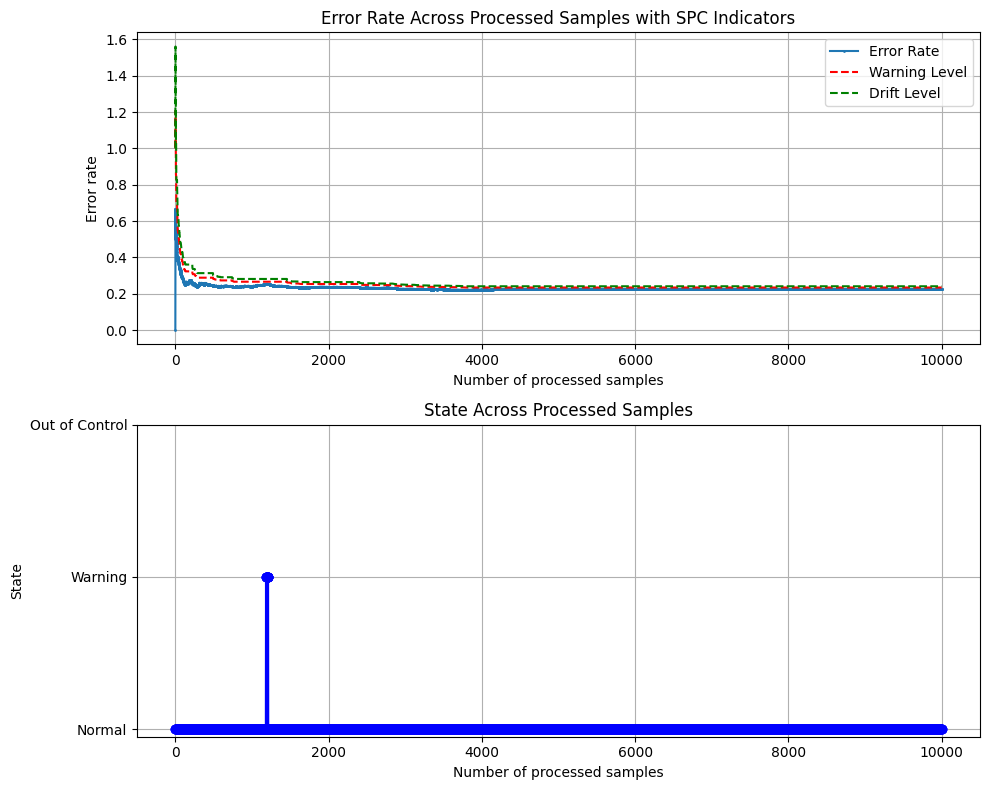

In [5]:
report = 1000
warn = -1
retrain = -1
for i in range(data_stream.shape[0]):
    status, y, y_pred = spc_detector.model_control(data_stream, i)        
    metric.update(y, y_pred)

    if (i+1)%report == 0: 
        print(f'{i+1} samples:', metric)

    if status == 'Warning Level' and warn == -1 and i!=0:
        warn = i
        retrain = -1
        #print(f'Warning after {i+1} samples')
    elif status == 'Out-control' and retrain == -1 and i!=0:
        #print(f'Re-train model after {i+1} samples')
        retrain = i
        warn = -1
    else:
        warn = -1
        retrain = -1

print(f'{i+1} samples:', metric)

# Plotting
spc_detector.process_plot()

## 4 - Findings and Conclusions

TBD: ...present our analysis to the performance with different ML models, etc...